### Import the dataset
The Boston Housing dataset is built into keras so we can easily import it

In [86]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

### Check the data sizes 

In [87]:
rows, cols = train_data.shape
print("There are " +str(rows) + " examples/rows and " + str(cols) + " features/columns in the training set")

There are 404 examples/rows and 13 features/columns in the training set


### Preprocess the data by Z-score normalization
In this way, the gradients will not become too large or too small and vanish
So we will subtract the mean and divide by the standard deviation

In [88]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [89]:
# Check to see the normalized data
import numpy as np
print("mean of the processed train data is: " + str(np.mean(train_data)))
print("std of the processed train data is: " + str(np.std(train_data)))

mean of the processed train data is: 2.602301889250862e-15
std of the processed train data is: 0.9999999999999994


### Build the neural network 
The architecture we've chosen to use has 3 layers.
<br>The first hidden layer has 64 neurons. 
<br> The second hidden layer has 64 neurons. 
<br>The output layer is just one neuron and no activations because we want to predict a real number

The loss function is the Mean Squared Error and we are optimizing it with RMSPROP. 
<br> We will monitor the minimization of the error by looking at the Mean Absolute Error everytime. 
<br> Check out the [Keras](https://faroit.github.io/keras-docs/0.2.0/optimizers/) documentation for various optimizers and default parameters.

In [104]:
from keras.models import Sequential
from keras.layers import Dense, Activation

def build_model():
    model = Sequential()
    model.add(Dense(64, activation='relu',input_shape=(train_data.shape[1],)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

### Let's build the model 

In [130]:
model = build_model()
history = model.fit(train_data,train_targets, validation_split=0.2, batch_size=64, epochs=500, verbose=0)
# If you don't want to see how the model is doing as it's training, change verbose=0

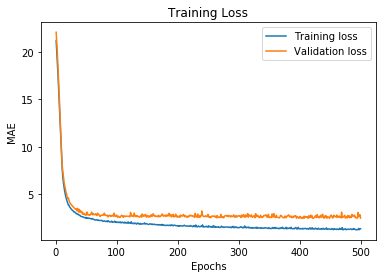

In [131]:
import matplotlib.pyplot as plt
train_loss = history.history['mean_absolute_error']
val_loss = history.history['val_mean_absolute_error']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')

plt.legend()
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.show()


In [117]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)
print("The error on the test set is: ", test_mae_score)
print("This means our predictions are off by $", test_mae_score*1000)

102/102 [==============================] - 0s 216us/step
The error on the test set is:  3.0749860277362897
This means we are off by $ 3074.9860277362895


### Things to take away 
MSE is commonly used for regression 
<br>MAE is a common regression metric to evaluate performance 
<br>When features in the dataset are of different ranges, it is helpful to normalize each feature as a preprocessing step
<br>When little data is available, it is typically better to use few hidden layers to avoid overfitting